# Steps
1) Load mask <br>
2) Get contours <br>
For every contour,<br>
3) Get bounding (rotated) rectangle <br>
4) Rotate the rectangle such that it is upright <br>
5) Crop the parts outside the bounding box

# Pipeline:
orig -> orig_cropped -> orig_cropped_rotated <br>
mask -> mask_gray -> mask_grayinv -> mask_contour

# TODO:
- add padding <br>
- min_area to be considered as boundingbox <br>
- artifacts created when bounding box touches edge of image <br>

In [4]:
import os
import sys
import cv2
import numpy as np
from scipy.misc import imread, imsave
import matplotlib
matplotlib.use('TkAgg') # so that you can close the plot window
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.monitor_interval = 0 # to silent warnings
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/z

In [3]:
# Specify constants and directories
# pylint: disaable=line-too-long
DIR_LAYER2_ORIG = "/Users/raimibinkarim/Desktop/CascadedFCN-Data/original-cropped/"
FILENAME_ORIG_HEAD = "/Users/raimibinkarim/Desktop/CascadedFCN-Data/original/Wound_"
FILENAME_MASK_HEAD = "/Users/raimibinkarim/Desktop/CascadedFCN-Data/masks-class-7/Wound_"
MIN_AREA = 50
BOX_COLOR = (70, 173, 212)
PADDING = 4 # pixels
ZOOM = 1.2
# pylint: enable=line-too-long

In [2]:
def eagerplot(image):
    """
    Quick plotting for debugging
    """
    plt.imshow(image, cmap="gray")
    plt.show()

def add_padding(vertices):
    """
    TODO: Add padding. 4 pairs of coordinates.
    """
    x0, y0 = vertices[0]
    x1, y1 = vertices[1]
    x2, y2 = vertices[2]
    x3, y3 = vertices[3]

    print(x3)

    return vertices

def get_bounding_box(idx=-1):
    """
    Get bounding box for one wound (original and mask), identified with idx
    And save it to DIR_L2_ORIG & DIR_L2_MASK directories
    """
    # If no index specified, assume this function is used for demo purposes.
    if idx == -1:
        idx = np.random.randint(1, 336+1) # 336 wounds

    # print("Processing Wound " + str(idx))

    # pylint: disable=line-too-long
    filename_orig = FILENAME_ORIG_HEAD + str(idx) + ".jpg"
    filename_mask = FILENAME_MASK_HEAD + str(idx) + ".png"
    # pylint: enable=line-too-long

    # Load original
    orig = imread(filename_orig, mode="RGB")

    # Load mask
    mask = imread(filename_mask, mode="RGB")

    # Convert mask to grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Invert mask
    mask_grayinv = 255 - mask_gray

    # Convert mask to binary mask
    _, mask_bin = cv2.threshold(src=mask_grayinv, thresh=0, maxval=1, type=cv2.THRESH_BINARY)

    # Get contours based on binary image
    mask_contour, contours, _ = cv2.findContours(mask_bin, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    # print("There are " + str(len(contours)) + " contour(s).")

    for contour in contours:

        # Ignore contours less than MIN_AREA
        if cv2.contourArea(contour) < MIN_AREA:
            continue
            
        # Get bounding rotated rectangle
        rect = cv2.minAreaRect(contour) # rect = (x,y,w,h,theta) where (x,y) is the centre point and theta is the angle of rotation
        box  = cv2.boxPoints(rect) 
        box  = np.int0(box)
        area = cv2.contourArea(contour)
        # print("This contour has area " + str(area))

        # Draws a rotated rectangle on original image
        cv2.drawContours(orig, contours=[box], contourIdx=0, color=BOX_COLOR, thickness=3)
        cv2.drawContours(mask_gray, contours=[box], contourIdx=0, color=BOX_COLOR, thickness=3)

        # Get coordinates, width, height, angle for cropping and rotating
        W = rect[1][0]
        H = rect[1][1]
        Xs = [i[0] for i in box]
        Ys = [i[1] for i in box]
        x1 = min(Xs)
        x2 = max(Xs)
        y1 = min(Ys)
        y2 = max(Ys)
        angle = rect[2]
        if angle < -45:
            angle += 90
            rotated = True
        else:
            rotated = False

        ctr  = (int((x1+x2)/2), int((y1+y2)/2))
        size = (int(ZOOM*(x2-x1)), int(ZOOM*(y2-y1)))
        # cv2.circle(orig, ctr, 10, BOX_COLOR, -1) # again this was mostly for debugging purposes

        # Rotate
        M = cv2.getRotationMatrix2D(center=(size[0]/2, size[1]/2), angle=angle, scale=1.0)

        # Retrieve pixel rectangle
        orig_cropped = cv2.getRectSubPix(orig, patchSize=size, center=ctr)
        # eagerplot(orig_cropped)

        # Rotate
        orig_cropped = cv2.warpAffine(orig_cropped, M=M, dsize=size)
        # eagerplot(orig_cropped)

        # Crop out artifacts
        croppedW = W if not rotated else H 
        croppedH = H if not rotated else W
        orig_cropped_rotated = cv2.getRectSubPix(orig_cropped, (int(croppedW*ZOOM), int(croppedH*ZOOM)), (size[0]/2, size[1]/2))
        # eagerplot(orig_cropped_rotated)

        # Add padding
        # box = addPadding(box)

    # Plot mask, orig, orig_cropped_rotated
    _, ax = plt.subplots(1,3)
    ax[0].imshow(mask_bin)
    ax[1].imshow(orig)
    ax[2].imshow(orig_cropped_rotated)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()

    plt.show()
    cv2.waitKey(0)

def process_layer1_output():
    """
    Takes in mask and orig images and output cropped originals to a directory
    """
    # Create directories if they do not exist
    if not os.path.isdir(DIR_LAYER2_ORIG):
        os.mkdir(DIR_LAYER2_ORIG)

    if not os.path.isdir(DIR_LAYER2_MASK):
        os.mkdir(DIR_LAYER2_MASK)
    
    # Get cropped images for all
    num_examples = 336
    for i in tqdm(range(1, num_examples+1)):
        get_bounding_box(i)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


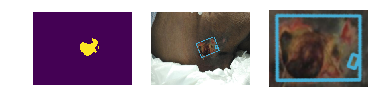

In [8]:
get_bounding_box()